In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,RobustScaler
from sklearn.metrics import mean_squared_error,r2_score

# Import the data

In [2]:
SPY = pd.read_pickle('combined_cleaned_add_with_QQQ.pkl')
SPY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2055 entries, 0 to 2054
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2055 non-null   datetime64[ns]
 1   SPY_Close            2055 non-null   float64       
 2   SPY_Volume           2055 non-null   int64         
 3   AAPL                 2055 non-null   float64       
 4   MSFT                 2055 non-null   float64       
 5   GOOG                 2055 non-null   float64       
 6   GLD                  2055 non-null   float64       
 7   SLV                  2055 non-null   float64       
 8   ^TNX                 2055 non-null   float64       
 9   DX-Y.NYB             2055 non-null   float64       
 10  JPY=X                2055 non-null   float64       
 11  EUR=X                2055 non-null   float64       
 12  USO                  2055 non-null   float64       
 13  UNG                  2055 non-nul

In [3]:
print(SPY.columns.to_list())

['ds', 'SPY_Close', 'SPY_Volume', 'AAPL', 'MSFT', 'GOOG', 'GLD', 'SLV', '^TNX', 'DX-Y.NYB', 'JPY=X', 'EUR=X', 'USO', 'UNG', 'BTC-USD', 'CPER', '^VIX', '^GDAXI', '^FTSE', '^RUT', '^N225', 'IEI', 'CNYUSD=X', '2Y_Yield', 'yield_curve', 'market_closed_count', 'yield_curve_term', 'high-low', 'before_high-low', 'SPY_RSI', 'RSI_rank', 'RSI_rank_2', 'EMA_20', 'EMA_50', 'EMA_200', 'EMA_20_50', 'EMA_50_200', 'EMA_50_diff', 'EMA_200_diff', 'SPY_std', 'SPY_mean', 'SPY_30', 'QQQ_Close', 'QQQ_Volume', 'qqq_std', 'qqq_mean']


## Add RSI , MACD & averages

In [ ]:
def calculate_rsi(prices, period=14):
    prices = pd.to_numeric(prices, errors='coerce')
    delta  = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

  # MACD Calculation
def calculate_macd(prices, fast=12, slow=26):
    prices = pd.Series(prices).astype(float).dropna()
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    return exp1 - exp2

# number of consecative up/down days     
def calculate_consecutive_streak(close_series: pd.Series) -> pd.Series:
    """
    Calculate the consecutive up/down streaks for a close price series.
    - If today's close > yesterday's, streak = previous_streak + 1 (or 1 if previous_streak <= 0)
    - If today's close < yesterday's, streak = previous_streak - 1 (or -1 if previous_streak >= 0)
    - If equal, streak = 0
    """
    streak = [0] * len(close_series)
    for i in range(1, len(close_series)):
        if close_series.iat[i] > close_series.iat[i - 1]:
            streak[i] = streak[i - 1] + 1 if streak[i - 1] > 0 else 1
        elif close_series.iat[i] < close_series.iat[i - 1]:
            streak[i] = streak[i - 1] - 1 if streak[i - 1] < 0 else -1
        else:
            streak[i] = 0
    return pd.Series(streak, index=close_series.index, name='consecutive_streak')

# Add some internal features 
#
def model_own_features(
    data: pd.DataFrame,
    column: str,
    keep_columns = None
) -> pd.DataFrame:
    """
    Add RSI, MACD, rolling means, std, and consecutive streak for `column`.
    Optionally preserve only keep_columns + new features.
    """
    df = data.copy()
    # Ensure numeric
    df[column] = pd.to_numeric(df[column], errors='coerce')
    
    # 1) RSI
    df['RSI_14'] = calculate_rsi(df[column], period=14)
    
    # 2) MACD
    #macd_df = calculate_macd(df[column])
    #df = df.join(macd_df)
    df['MACD'] = calculate_macd(df[column])
    # 3) Rolling stats
    df['30d_mean'] = df[column].rolling(30).mean()
    df['5d_mean']  = df[column].rolling(5).mean()
    df['5d_std']   = df[column].rolling(5).std()
    
    # 4) Consecutive streak
    df['streak'] = calculate_consecutive_streak(df[column])
    
    # 5) Select output columns
    if keep_columns is not None:
        # always include the new features
        new_feats = ['RSI_14', 'MACD', '30d_mean', '5d_mean', '5d_std', 'streak']
        df = df[ keep_columns + new_feats ]

    df = df.dropna()

    return df


In [ ]:
# calculate the cosecative returns
def calculate_consecutive_return(close_series: pd.Series, streak_series: pd.Series) -> pd.Series:
    """
    Calculate the percentage change over the span of the consecutive streak.
    - If streak == 0: 0
    - Else: (close_today / close_n_days_ago - 1) * 100, where n = abs(streak)
    """
    returns = []
    prices = close_series.values
    streaks = streak_series.values.astype(int)
    for i, (price, streak) in enumerate(zip(prices, streaks)):
        n = abs(streak)
        if n > 0 and i - n >= 0:
            prev_price = prices[i - n]
            returns.append((price / prev_price - 1) * 100)
        else:
            returns.append(0.0)
    return pd.Series(returns, index=close_series.index, name='abs_consecutive_change')



In [ ]:
result = model_own_features(
    data=SPY,
    column='SPY_Close',
    keep_columns=['SPY_Close','high-low','before_high-low']
)

result['abs_consecutive_change'] = calculate_consecutive_return(result[column], df['streak'])

result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2026 entries, 29 to 2054
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SPY_Close        2026 non-null   float64
 1   high-low         2026 non-null   float64
 2   before_high-low  2026 non-null   float64
 3   RSI_14           2026 non-null   float64
 4   MACD             2026 non-null   float64
 5   30d_mean         2026 non-null   float64
 6   5d_mean          2026 non-null   float64
 7   5d_std           2026 non-null   float64
 8   streak           2026 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 158.3 KB


In [116]:
result = result.reset_index(drop=True)

result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SPY_Close        2026 non-null   float64
 1   high-low         2026 non-null   float64
 2   before_high-low  2026 non-null   float64
 3   RSI_14           2026 non-null   float64
 4   MACD             2026 non-null   float64
 5   30d_mean         2026 non-null   float64
 6   5d_mean          2026 non-null   float64
 7   5d_std           2026 non-null   float64
 8   streak           2026 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 142.6 KB


### Creat a sequence

In [ ]:
def create_sequences_multifeature(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i, 0])  # תחזית רק למחיר
    return np.array(X), np.array(y)

window_size = 30
#X, y = create_sequences_multifeature(scaled_data, window_size)

### Scaling, Creating a sequence & spliting the data

In [126]:
scaler = MinMaxScaler() # scale the data
def prepare_RNN_data(data,window_size,scaler,split_ratio=0.8):
    
    scaled_data = scaler.fit_transform(data)

    X, y = create_sequences_multifeature(scaled_data, window_size)
    split = int(split_ratio * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    return X_train, X_test, y_train, y_test ,X

In [127]:
window_size = 30
X_train, X_test, y_train, y_test,X = prepare_RNN_data(result, 30,scaler) # for sequence length of 30

# Search for the best parameters

In [134]:
import itertools

def search_best_model(
    model_type: str,
    X_train, y_train,
    X_val, y_val,
    window_size: int,
    layer_options=(1, 2, 3),
    unit_options=(32, 64, 98),
    epochs=20,
    batch_size=32,
    patience=3,
    learning_rate=0.001
):
    """
    Grid‐search over small GRU/LSTM architectures to minimize validation MSE.
    
    Parameters
    ----------
    model_type : {"GRU", "LSTM"}
        Which recurrent cell to use.
    X_train, y_train : np.ndarray
        Training data.
    X_val, y_val : np.ndarray
        Validation data.
    window_size : int
        Number of timesteps in each input sequence.
    layer_options : iterable of int
        You’ll try each of these as possible numbers of recurrent layers.
    unit_options : iterable of int
        Possible unit‐counts for each layer.
    epochs : int
        Maximum epochs per architecture.
    batch_size : int
    patience : int
        EarlyStopping patience on val_loss.
    learning_rate : float

    Returns
    -------
    best_model : keras.Model
        The model instance that achieved the lowest val_loss.
    best_val_loss : float
        Its validation loss.
    best_config : (n_layers, units_tuple)
        The layer‐count and the specific units in each layer.
    """
    if model_type not in ("GRU", "LSTM"):
        raise ValueError(f"model_type must be 'GRU' or 'LSTM', got {model_type!r}")
    Cell = GRU if model_type == "GRU" else LSTM

    best_val_loss = float("inf")
    best_model     = None
    best_config    = None

    for n_layers in layer_options:
        for units_combo in itertools.product(unit_options, repeat=n_layers):
            # Build model
            model = Sequential()
            for i, units in enumerate(units_combo):
                return_seq = (i < n_layers - 1)
                if i == 0:
                    model.add(
                        Cell(
                            units,
                            return_sequences=return_seq,
                            input_shape=(window_size, X_train.shape[2])
                        )
                    )
                else:
                    model.add(Cell(units, return_sequences=return_seq))
            model.add(Dense(1))

            # Compile & train
            opt = Adam(learning_rate=learning_rate)
            model.compile(optimizer=opt, loss="mse")
            es = EarlyStopping(
                monitor="val_loss",
                patience=patience,
                restore_best_weights=True
            )
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[es],
                verbose=0
            )

            val_loss = min(history.history["val_loss"])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_config   = (n_layers, units_combo)
                best_model    = model

    return best_model, best_val_loss, best_config


In [147]:
best_model, best_loss, best_cfg = search_best_model(
    model_type="GRU",                # or "LSTM"
    X_train=X_train, y_train=y_train,
    X_val=X_test,  y_val=y_test,
    window_size=window_size,
    layer_options=[1,2,3],
    unit_options=[32,64,92],
    epochs=20,
    batch_size=32,
    patience=3,
    learning_rate=0.004
)
print("Best loss:", best_loss, "Config:", best_cfg)


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best loss: 0.0003635399043560028 Config: (1, (92,))


# Training function

In [119]:


def train_lstm(
    X_train, y_train,
    learning_rate=0.001,
    epochs=20,
    num_layers=1,
    units=(64,),
    window_size=None,
    batch_size=32,
    validation_split=0.2,
    patience=3,
    checkpoint_path='best_lstm.h5',
    dense_units=None,
    dense_activation='relu'
):
    """
    Builds, compiles, and trains a multi-layer LSTM model, with optional intermediate Dense layer.

    Parameters:
    - X_train, y_train: training data arrays
    - learning_rate: float, optimizer learning rate
    - epochs: int, max training epochs
    - num_layers: int, number of LSTM layers
    - units: tuple of ints, units per LSTM layer (length must equal num_layers)
    - window_size: int, sequence length (timesteps)
    - batch_size: int
    - validation_split: float
    - patience: int, early stopping patience
    - checkpoint_path: str, filepath to save best model
    - dense_units: int or None, if specified adds Dense(dense_units, activation=dense_activation)
    - dense_activation: str, activation for the optional Dense layer

    Returns:
    - model: trained Keras model
    - history: training history
    """
    if num_layers != len(units):
        raise ValueError(f"num_layers ({num_layers}) must equal length of units tuple ({len(units)})")
    
    opt = Adam(learning_rate=learning_rate)
    model = Sequential()
    
    # Add LSTM layers
    for i, u in enumerate(units):
        return_seq = (i < num_layers - 1)
        if i == 0:
            model.add(LSTM(u, return_sequences=return_seq, input_shape=(window_size, X_train.shape[2])))
        else:
            model.add(LSTM(u, return_sequences=return_seq))
    
    # Optional Dense layer
    if dense_units is not None:
        model.add(Dense(dense_units, activation=dense_activation))
    # Output layer
    model.add(Dense(1))
    
    model.compile(optimizer=opt, loss='mse')
    
    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    chk = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                          save_best_only=True, verbose=1)
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[es, chk],
        verbose=1
    )
    return model, history

def train_gru(
    X_train, y_train,
    learning_rate=0.001,
    epochs=20,
    num_layers=1,
    units=(64,),
    window_size=None,
    batch_size=32,
    validation_split=0.2,
    patience=3,
    checkpoint_path='best_gru.h5',
    dense_units=None,
    dense_activation='relu'
):
    """
    Builds, compiles, and trains a multi-layer GRU model (on GPU if available), with optional Dense layer.

    Parameters: same as train_lstm.
    """
    if num_layers != len(units):
        raise ValueError(f"num_layers ({num_layers}) must equal length of units tuple ({len(units)})")
    
    # Choose device
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
    with tf.device(device):
        opt = Adam(learning_rate=learning_rate)
        model = Sequential()
        # Add GRU layers
        for i, u in enumerate(units):
            return_seq = (i < num_layers - 1)
            if i == 0:
                model.add(GRU(u, return_sequences=return_seq, input_shape=(window_size, X_train.shape[2])))
            else:
                model.add(GRU(u, return_sequences=return_seq))
        # Optional Dense layer
        if dense_units is not None:
            model.add(Dense(dense_units, activation=dense_activation))
        # Output layer
        model.add(Dense(1))
        model.compile(optimizer=opt, loss='mse')
    
    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    chk = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                          save_best_only=True, verbose=1)
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[es, chk],
        verbose=1
    )
    return model, history


### LSTM

In [120]:
model_lstm = train_lstm(
    X_train, y_train,
    learning_rate=0.004,
    epochs=30,
    num_layers=1,
    units=(90,),
    window_size=30,
    batch_size=16,
    validation_split=0.2,
    patience=5,
    checkpoint_path='best_lstm.h5',
    dense_units=None,
    dense_activation='relu'
)[0]

Epoch 1/30


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0180
Epoch 1: val_loss improved from inf to 0.00036, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0178 - val_loss: 3.6468e-04
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0742e-04
Epoch 2: val_loss improved from 0.00036 to 0.00032, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0746e-04 - val_loss: 3.1753e-04
Epoch 3/30
72/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4550e-04
Epoch 3: val_loss did not improve from 0.00032
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4526e-04 - val_loss: 4.0274e-04
Epoch 4/30
72/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5840e-04
Epoch 4: val_loss improved from 0.00032 to 0.00029, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5460e-04 - val_loss: 2.8763e-04
Epoch 5/30
71/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6862e-04
Epoch 5: val_loss did not improve from 0.00029
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7055e-04 - val_loss: 3.1919e-04
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5779e-04
Epoch 6: val_loss did not improve from 0.00029
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5809e-04 - val_loss: 2.9439e-04
Epoch 7/30
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6406e-04
Epoch 7: val_loss did not improve from 0.00029
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6546e-04 - val_loss: 8.3553e-04
Epoch 8/30
69/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2281e-04
Epoch 8: val_loss improved from 0.00029 to 0.00026, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1674e-04 - val_loss: 2.5981e-04
Epoch 9/30
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8496e-04
Epoch 9: val_loss improved from 0.00026 to 0.00025, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8494e-04 - val_loss: 2.5249e-04
Epoch 10/30
72/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5074e-04
Epoch 10: val_loss did not improve from 0.00025
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5194e-04 - val_loss: 3.1687e-04
Epoch 11/30
69/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2784e-04
Epoch 11: val_loss improved from 0.00025 to 0.00024, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1986e-04 - val_loss: 2.3993e-04
Epoch 12/30
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0391e-04
Epoch 12: val_loss did not improve from 0.00024
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0200e-04 - val_loss: 2.4447e-04
Epoch 13/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6888e-04
Epoch 13: val_loss improved from 0.00024 to 0.00023, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6896e-04 - val_loss: 2.3031e-04
Epoch 14/30
69/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4580e-04
Epoch 14: val_loss did not improve from 0.00023
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4569e-04 - val_loss: 4.6910e-04
Epoch 15/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9606e-04
Epoch 15: val_loss did not improve from 0.00023
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9590e-04 - val_loss: 2.4256e-04
Epoch 16/30
70/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7275e-04
Epoch 16: val_loss improved from 0.00023 to 0.00023, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7052e-04 - val_loss: 2.2732e-04
Epoch 17/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5571e-04
Epoch 17: val_loss did not improve from 0.00023
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5552e-04 - val_loss: 2.5846e-04
Epoch 18/30
70/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3069e-04
Epoch 18: val_loss did not improve from 0.00023
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3321e-04 - val_loss: 2.4291e-04
Epoch 19/30
70/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4703e-04
Epoch 19: val_loss did not improve from 0.00023
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4642e-04 - val_loss: 2.8017e-04
Epoch 20/30
74/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4209e-04
Epoch 20: val_loss improved from 0.00023 to 0.00023, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4240e-04 - val_loss: 2.2624e-04
Epoch 21/30
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5802e-04
Epoch 21: val_loss improved from 0.00023 to 0.00022, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5784e-04 - val_loss: 2.1652e-04
Epoch 22/30
72/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5555e-04
Epoch 22: val_loss did not improve from 0.00022
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5449e-04 - val_loss: 2.5976e-04
Epoch 23/30
71/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3012e-04
Epoch 23: val_loss improved from 0.00022 to 0.00021, saving model to best_lstm.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3073e-04 - val_loss: 2.0525e-04
Epoch 24/30
71/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3496e-04
Epoch 24: val_loss did not improve from 0.00021
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3597e-04 - val_loss: 2.0995e-04
Epoch 25/30
71/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3741e-04
Epoch 25: val_loss did not improve from 0.00021
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3952e-04 - val_loss: 3.1235e-04
Epoch 26/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4478e-04
Epoch 26: val_loss did not improve from 0.00021
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4469e-04 - val_loss: 2.3216e-04
Epoch 27/30
70/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6729e-04
Epoch 27: val_loss did not improve from 0.00021
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6338e-04 - val_loss: 2.0854e-04
Epoch 28/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4982e-04
Epoch 28: val_loss did not improve from 0.00021
80/80

### GRU

In [144]:
model_gru = train_gru(
    X_train, y_train,
    learning_rate=0.004,
    epochs=30,
    num_layers=1,
    units=(92,),
    window_size=30,
    batch_size=32,
    validation_split=0.2,
    patience=5,
    checkpoint_path='best_gru.h5',
    dense_units=None,
    dense_activation='relu'
)[0]

Epoch 1/30


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0239
Epoch 1: val_loss improved from inf to 0.00099, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0224 - val_loss: 9.8626e-04
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8646e-04
Epoch 2: val_loss improved from 0.00099 to 0.00029, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8376e-04 - val_loss: 2.9080e-04
Epoch 3/30
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6386e-04
Epoch 3: val_loss improved from 0.00029 to 0.00026, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6490e-04 - val_loss: 2.6034e-04
Epoch 4/30
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6509e-04
Epoch 4: val_loss did not improve from 0.00026
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6460e-04 - val_loss: 2.8971e-04
Epoch 5/30
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5025e-04
Epoch 5: val_loss improved from 0.00026 to 0.00024, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5064e-04 - val_loss: 2.3679e-04
Epoch 6/30
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4689e-04
Epoch 6: val_loss did not improve from 0.00024
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4644e-04 - val_loss: 2.3723e-04
Epoch 7/30
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4075e-04
Epoch 7: val_loss improved from 0.00024 to 0.00022, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4067e-04 - val_loss: 2.1858e-04
Epoch 8/30
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5079e-04
Epoch 8: val_loss did not improve from 0.00022
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4979e-04 - val_loss: 2.3405e-04
Epoch 9/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2796e-04
Epoch 9: val_loss improved from 0.00022 to 0.00020, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2812e-04 - val_loss: 2.0228e-04
Epoch 10/30
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2140e-04
Epoch 10: val_loss did not improve from 0.00020
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2230e-04 - val_loss: 2.1085e-04
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2550e-04
Epoch 11: val_loss did not improve from 0.00020
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2561e-04 - val_loss: 2.7220e-04
Epoch 12/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3119e-04
Epoch 12: val_loss improved from 0.00020 to 0.00020, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3111e-04 - val_loss: 2.0123e-04
Epoch 13/30
35/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2010e-04
Epoch 13: val_loss did not improve from 0.00020
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2019e-04 - val_loss: 2.0125e-04
Epoch 14/30
34/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1896e-04
Epoch 14: val_loss did not improve from 0.00020
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1864e-04 - val_loss: 2.4193e-04
Epoch 15/30
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2490e-04
Epoch 15: val_loss improved from 0.00020 to 0.00019, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2611e-04 - val_loss: 1.9013e-04
Epoch 16/30
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2756e-04
Epoch 16: val_loss did not improve from 0.00019
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2742e-04 - val_loss: 2.0392e-04
Epoch 17/30
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3976e-04
Epoch 17: val_loss did not improve from 0.00019
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3866e-04 - val_loss: 2.0464e-04
Epoch 18/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3930e-04
Epoch 18: val_loss improved from 0.00019 to 0.00018, saving model to best_gru.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3981e-04 - val_loss: 1.8363e-04
Epoch 19/30
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0739e-04
Epoch 19: val_loss did not improve from 0.00018
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0804e-04 - val_loss: 1.8899e-04
Epoch 20/30
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3598e-04
Epoch 20: val_loss did not improve from 0.00018
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3662e-04 - val_loss: 2.3293e-04
Epoch 21/30
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2681e-04
Epoch 21: val_loss did not improve from 0.00018
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2751e-04 - val_loss: 2.6995e-04
Epoch 22/30
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4436e-04
Epoch 22: val_loss did not improve from 0.00018
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4441e-04 - val_loss: 2.1594e-04
Epoch 23/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1639e-04
Epoch 23: val_loss did not improve from 0.00018


### Load the best model

In [ ]:
from tensorflow.keras.models import load_model

# 1. Point to the same filepath you used in ModelCheckpoint
checkpoint_path = "best_lstm.h5"   # or "best_gru.h5", etc.

# 2. Load the entire model (architecture + weights + optimizer state)
best_model = load_model(checkpoint_path)

# 3. Now you can call .predict(), .evaluate(), etc.
preds = best_model.predict(X_test)

## Making a prediction and inversing the scale:

In [145]:
pred_lstm = model_lstm.predict(X_test)
pred_gru = model_gru.predict(X_test)

# reset the scaler to the original price range
price_scaler = MinMaxScaler()
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
pred_lstm = price_scaler.inverse_transform(pred_lstm)
pred_gru = price_scaler.inverse_transform(pred_gru)
y_test_actual = price_scaler.inverse_transform(y_test.reshape(-1, 1))
#y_test_actual = price_scaler.inverse_transform(y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [146]:
mse_lstm = mean_squared_error(y_test_actual, pred_lstm)
mse_gru = mean_squared_error(y_test_actual, pred_gru)

r2_lstm = r2_score(y_test_actual, pred_lstm)
r2_gru = r2_score(y_test_actual, pred_gru)

print(f'LSTM - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}')
print(f'GRU  - MSE: {mse_gru:.4f}, R²: {r2_gru:.4f}')

LSTM - MSE: 5045.6500, R²: 0.9831
GRU  - MSE: 5646.8779, R²: 0.9811


In [130]:
split = split = int(0.8 * len(X))
dates = result.index[window_size + split:]

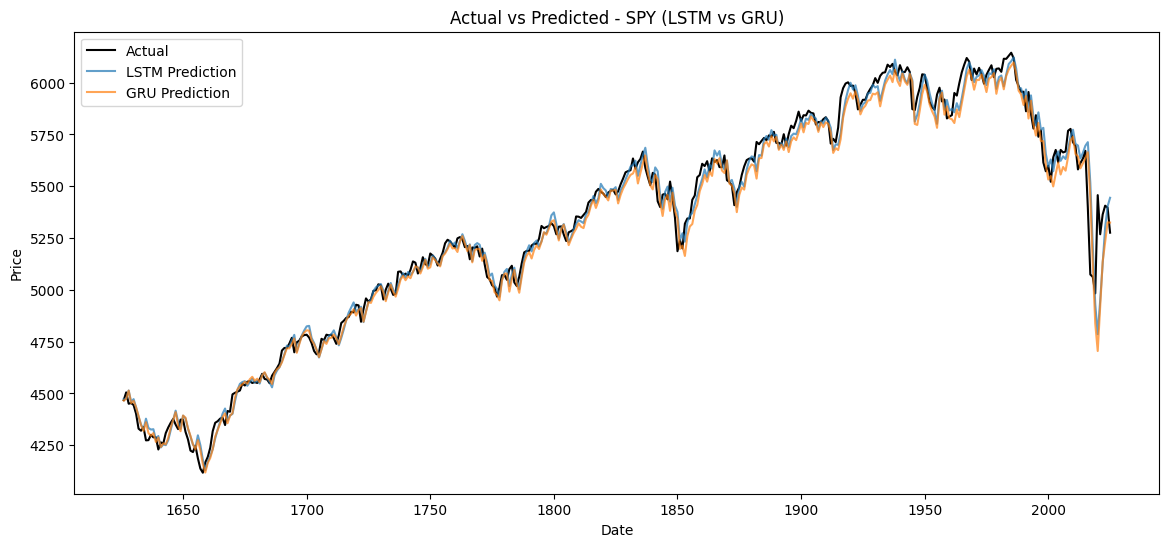

In [133]:
ticker = 'SPY'
plt.figure(figsize=(14,6))
plt.plot(dates, y_test_actual, label='Actual', color='black')
plt.plot(dates, pred_lstm, label='LSTM Prediction', alpha=0.7)
plt.plot(dates, pred_gru, label='GRU Prediction', alpha=0.7)
plt.title(f'Actual vs Predicted - {ticker} (LSTM vs GRU)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(False)
plt.show()

# Forcasting return data 